# Imports

In [38]:
# Cell 2 — Imports
import pandas as pd
from calendar import monthrange
from pulp import (
    LpProblem, LpMinimize, LpVariable, LpStatus, lpSum, value
)

# Config 

In [39]:
# Cell 4 — Config / Inputs (edit these)

# Months (1..12). You can change this to any list of months you model.
months = list(range(1, 13))

# Target power (MW) required EACH month (can be constant or month-by-month)
T_MW = {m: 50 for m in months}

# Choose a year for hours-per-month conversion (leap-year matters for Feb)
year_for_hours = 2026


############################
# Tiered supply definitions
############################
# Define each SUPPLY (e.g. "solar") once.
# - available_mw: total capacity available (MW) per month
# - tiers: ordered list of price tiers with cumulative breakpoints (MW)
# - use: min/max utilization multipliers in [0,1] applied to TOTAL supply capacity
#   - min: minimum generation as a fraction of nominal capacity ("must-run" if > 0)
#   - max: maximum generation as a fraction of nominal capacity (derating if < 1)
# - payment: per-tier payment mode
#   - "take_or_pay": pay for GENERATED energy in that tier (even if spilled/unused)
#   - "take_and_pay": pay only for USED energy from that tier
# - sell_unused: optional resale of UNUSED (generated-but-not-used) energy at supply level
#   - enabled: True/False
#   - tariff_usd_per_mwh: resale price applied to sold unused energy (USD/MWh)

# Example for solar tiers:
#   0..30 MW  @ 165
#   30..50 MW @ 180
#   50..inf   @ 220

# Notes:
# - Each tier uses a cumulative breakpoint 'up_to_mw'. Use None for "no upper limit".
# - The optimization will split each supply into tier-variables internally.
# - If sell_unused is enabled, the optimizer may generate above demand (up to use.max)

#
supply_defs = {
    "solar": {
        "available_mw": {
            1: 28, 2: 28, 3: 30, 4: 60, 5: 60, 6: 60,
            7: 60, 8: 60, 9: 60, 10: 30, 11: 28, 12: 28,
        },
        "use": {"min": 1.0, "max": 1.0},
        "sell_unused": {"enabled": True, "tariff_usd_per_mwh": 200.0},
        "tiers": [
            {"name": "base", "up_to_mw": 30, "tariff_usd_per_mwh": 168, "payment": "take_or_pay"},
            {"name": "surplus", "up_to_mw": 50, "tariff_usd_per_mwh": 170, "payment": "take_or_pay"},
            {"name": "excess", "up_to_mw": None, "tariff_usd_per_mwh": 172, "payment": "take_and_pay"},
        ],
    },

    # Non-tiered supplies can be represented with a single tier (up_to_mw=None)
    "diesel": {
        "available_mw": 50,
        "use": {"min": 0.0, "max": 1.0},
        "sell_unused": {"enabled": False, "tariff_usd_per_mwh": 0.0},
        "tiers": [
            {"name": "all", "up_to_mw": None, "tariff_usd_per_mwh": 500, "payment": "take_and_pay"},
        ],
    },

    "grid": {
        "available_mw": 0,
        "use": {"min": 0.0, "max": 1.0},
        "sell_unused": {"enabled": False, "tariff_usd_per_mwh": 0.0},
        "tiers": [
            {"name": "all", "up_to_mw": None, "tariff_usd_per_mwh": 110, "payment": "take_or_pay"},
        ],
    },
}


#########################
# Helpers / normalization
#########################
from calendar import monthrange


def hours_in_month(year: int, month: int) -> int:
    return monthrange(year, month)[1] * 24


def _by_month(val):
    """Normalize either a constant number or {month: number} into {month: float}."""
    if isinstance(val, (int, float)):
        return {m: float(val) for m in months}
    if isinstance(val, dict):
        if len(val) == 0:
            raise ValueError("Empty month mapping")
        default_val = float(next(iter(val.values())))
        return {m: float(val.get(m, default_val)) for m in months}
    raise TypeError(f"Expected number or dict[month->number], got {type(val)}")


def expand_tiered_supplies(defs: dict, months: list[int]) -> tuple[list[str], dict, dict, dict, dict, dict, dict]:
    """Expand supply_defs into tier-supply names, capacities, tariffs, payment modes, and supply-level settings.

    Returns:
      - tier_supplies: list like ["solar__base", "solar__surplus", ...]
      - cap_mw: dict[tier_supply][month] -> MW capacity for that tier in that month
      - tariff: dict[tier_supply] -> USD/MWh
      - tier_meta: dict[tier_supply] -> {"supply": parent, "tier": tier_name}
      - payment: dict[tier_supply] -> "take_or_pay" | "take_and_pay"
      - supply_use: dict[parent_supply] -> {"min": float, "max": float}
      - supply_sell_unused: dict[parent_supply] -> {"enabled": bool, "tariff_usd_per_mwh": float}
    """
    valid_payment = {"take_or_pay", "take_and_pay"}

    tier_supplies: list[str] = []
    cap_mw: dict[str, dict[int, float]] = {}
    tariff: dict[str, float] = {}
    tier_meta: dict[str, dict[str, str]] = {}
    payment: dict[str, str] = {}
    supply_use: dict[str, dict[str, float]] = {}
    supply_sell_unused: dict[str, dict[str, float | bool]] = {}

    for supply_name, cfg in defs.items():
        if "available_mw" not in cfg or "tiers" not in cfg:
            raise ValueError(f"Supply '{supply_name}' must have 'available_mw' and 'tiers'")

        use_cfg = cfg.get("use", {"min": 0.0, "max": 1.0})
        umin = float(use_cfg.get("min", 0.0))
        umax = float(use_cfg.get("max", 1.0))
        if not (0.0 <= umin <= umax <= 1.0):
            raise ValueError(
                f"Supply '{supply_name}' has invalid use bounds: min={umin}, max={umax}. "
                "Expected 0 <= min <= max <= 1."
            )
        supply_use[supply_name] = {"min": umin, "max": umax}

        sell_cfg = cfg.get("sell_unused", {"enabled": False, "tariff_usd_per_mwh": 0.0})
        sell_enabled = bool(sell_cfg.get("enabled", False))
        sell_tariff = float(sell_cfg.get("tariff_usd_per_mwh", 0.0))
        if sell_tariff < 0.0:
            raise ValueError(f"Supply '{supply_name}' sell_unused tariff must be >= 0")
        supply_sell_unused[supply_name] = {"enabled": sell_enabled, "tariff_usd_per_mwh": sell_tariff}

        avail = _by_month(cfg["available_mw"])
        tiers = cfg["tiers"]
        if not isinstance(tiers, list) or len(tiers) == 0:
            raise ValueError(f"Supply '{supply_name}' tiers must be a non-empty list")

        prev_bp = 0.0
        for i, t in enumerate(tiers):
            tier_name = str(t.get("name", f"tier{i+1}"))
            bp = t.get("up_to_mw", None)
            tier_tariff = float(t["tariff_usd_per_mwh"])  # required
            pay_mode = str(t.get("payment", "take_and_pay"))
            if pay_mode not in valid_payment:
                raise ValueError(
                    f"Supply '{supply_name}' tier '{tier_name}' has invalid payment='{pay_mode}'. "
                    f"Expected one of {sorted(valid_payment)}."
                )

            tier_supply = f"{supply_name}__{tier_name}"
            tier_supplies.append(tier_supply)
            tariff[tier_supply] = tier_tariff
            tier_meta[tier_supply] = {"supply": supply_name, "tier": tier_name}
            payment[tier_supply] = pay_mode

            # Convert cumulative breakpoints into incremental tier capacities
            tier_cap = {}
            for m in months:
                a = float(avail[m])
                if bp is None:
                    inc = max(0.0, a - prev_bp)
                else:
                    bp_f = float(bp)
                    inc = max(0.0, min(a, bp_f) - min(a, prev_bp))
                tier_cap[m] = inc
            cap_mw[tier_supply] = tier_cap

            if bp is None:
                prev_bp = float("inf")
            else:
                prev_bp = float(bp)

    return tier_supplies, cap_mw, tariff, tier_meta, payment, supply_use, supply_sell_unused


# Precompute monthly hours
H = {m: hours_in_month(year_for_hours, m) for m in months}

# Expand tiered supplies
supplies, Cap_MW, tariff_usd_per_mwh, tier_meta, payment_mode, supply_use, supply_sell_unused = expand_tiered_supplies(supply_defs, months)

# Quick sanity checks
for s in supplies:
    if s not in tariff_usd_per_mwh:
        raise ValueError(f"Missing tariff for '{s}'")
    if s not in Cap_MW:
        raise ValueError(f"Missing capacity for '{s}'")
    if s not in payment_mode:
        raise ValueError(f"Missing payment mode for '{s}'")

for supply_name, u in supply_use.items():
    if "min" not in u or "max" not in u:
        raise ValueError(f"Missing use bounds for supply '{supply_name}'")

for supply_name, s_cfg in supply_sell_unused.items():
    if "enabled" not in s_cfg or "tariff_usd_per_mwh" not in s_cfg:
        raise ValueError(f"Missing sell_unused config for supply '{supply_name}'")

# Model

In [40]:
# Cell 6 — Model (PuLP) + Solve + Results (tiered supplies + optional resale)
#
# This model supports tiered costs for ANY supply by splitting it into tier-supplies,
# each with its own MW capacity and tariff. Because higher tiers are (typically)
# more expensive, the optimizer will naturally fill "base" before "surplus" before
# "excess" within the same supply.
#
# Supply-level use bounds (min/max in [0,1]) apply to TOTAL generation for each parent supply:
#   use_min * total_capacity <= total_generated <= use_max * total_capacity
#
# Payment per tier depends on `payment_mode[tier_supply]`:
#   - take_or_pay: pay for ALL GENERATED energy in that tier (used + sold + spilled)
#   - take_and_pay: pay for DELIVERED energy (used + sold), i.e., what mine receives
#     Note: Mine receives and pays for delivered energy, then resells the "sold" portion
#
# Optional resale of unused energy:
#   - Define per supply via `sell_unused: {enabled, tariff_usd_per_mwh}` in Cell 4
#   - The model can allocate part of (generated - used_for_mine) to `Sold_MW` and earn revenue
#   - Mine pays for delivered energy (used + sold) but receives proceeds from resales
#   - Net cost = Gross cost - Sold value (proceeds reduce overall cost)

from pulp import LpProblem, LpMinimize, LpVariable, LpStatus, lpSum, value
import numpy as np
import pandas as pd

# Group tiers by parent supply
parent_supplies = sorted({tier_meta[s]["supply"] for s in supplies})
tiers_by_parent = {p: [s for s in supplies if tier_meta[s]["supply"] == p] for p in parent_supplies}

# Decision variables:
# - g_mw: generated MW per tier-supply (0..tier capacity)
# - u_mw: used MW for mine per tier-supply (0..generated)
# - sell_mw: sold MW per tier-supply (0..generated-unused_for_mine), enabled per parent supply
g_mw = {}
u_mw = {}
sell_mw = {}
for s in supplies:
    parent = tier_meta[s]["supply"]
    sell_enabled = bool(supply_sell_unused[parent]["enabled"])
    for m in months:
        cap = float(Cap_MW[s][m])
        g_mw[(s, m)] = LpVariable(f"g_{s}_{m}", lowBound=0.0, upBound=cap)
        u_mw[(s, m)] = LpVariable(f"u_{s}_{m}", lowBound=0.0, upBound=cap)
        sell_mw[(s, m)] = LpVariable(
            f"sell_{s}_{m}",
            lowBound=0.0,
            upBound=(cap if sell_enabled else 0.0),
        )

# Create optimization model
model = LpProblem("Monthly_Power_Supply_Cost_Minimization", LpMinimize)

# Objective: minimize net cost = gross payment cost - sold value
gross_cost_terms = []
sold_value_terms = []
for s in supplies:
    parent = tier_meta[s]["supply"]
    sell_tariff = float(supply_sell_unused[parent]["tariff_usd_per_mwh"])
    for m in months:
        delivered_mw = u_mw[(s, m)] + sell_mw[(s, m)]
        paid_mw = g_mw[(s, m)] if payment_mode[s] == "take_or_pay" else delivered_mw
        gross_cost_terms.append(paid_mw * H[m] * tariff_usd_per_mwh[s])
        sold_value_terms.append(sell_mw[(s, m)] * H[m] * sell_tariff)

model += (lpSum(gross_cost_terms) - lpSum(sold_value_terms)), "Total_Net_Cost_USD"

# Constraints:
# 1) Mine-use cannot exceed generated per tier-supply
for s in supplies:
    for m in months:
        model += (u_mw[(s, m)] <= g_mw[(s, m)], f"UseLeqGen_{s}_{m}")

# 2) Sold cannot exceed remaining generated after mine-use per tier-supply
for s in supplies:
    for m in months:
        model += (sell_mw[(s, m)] <= g_mw[(s, m)] - u_mw[(s, m)], f"SellLeqUnused_{s}_{m}")

# 3) Supply-level min/max generation constraints (apply to total generation across tiers)
for p in parent_supplies:
    umin = float(supply_use[p]["min"])
    umax = float(supply_use[p]["max"])
    for m in months:
        total_cap = lpSum(Cap_MW[s][m] for s in tiers_by_parent[p])
        total_gen = lpSum(g_mw[(s, m)] for s in tiers_by_parent[p])
        model += (total_gen >= umin * total_cap, f"MinUse_{p}_{m}")
        model += (total_gen <= umax * total_cap, f"MaxUse_{p}_{m}")

# 4) Meet mine demand exactly each month
for m in months:
    model += (
        lpSum(u_mw[(s, m)] for s in supplies) == T_MW[m],
        f"TargetPower_Month_{m}",
    )

# Solve
_ = model.solve()
status_str = LpStatus[model.status]
print("Status:", status_str)

if status_str != "Optimal":
    raise RuntimeError(
        f"Optimization did not solve to Optimal. Status={status_str}. "
        "Check feasibility, capacities, targets, and use bounds."
    )

net_obj = float(value(model.objective))
print("Total net cost (USD):", round(net_obj, 2))

# Build detailed results table
rows = []
for m in months:
    # precompute supply total capacity for convenience in reporting
    supply_cap_mw = {p: float(sum(Cap_MW[s][m] for s in tiers_by_parent[p])) for p in parent_supplies}
    for s in supplies:
        gv = value(g_mw[(s, m)])
        uv = value(u_mw[(s, m)])
        sv = value(sell_mw[(s, m)])
        gv = float(gv) if gv is not None else 0.0
        uv = float(uv) if uv is not None else 0.0
        sv = float(sv) if sv is not None else 0.0

        supply_name = tier_meta[s]["supply"]
        tier_name = tier_meta[s]["tier"]

        cap_mw = float(Cap_MW[s][m])
        use_min = float(supply_use[supply_name]["min"])
        use_max = float(supply_use[supply_name]["max"])
        supply_total_cap = float(supply_cap_mw[supply_name])
        min_gen_supply_mw = supply_total_cap * use_min
        max_gen_supply_mw = supply_total_cap * use_max

        generated_mw = gv
        used_mw = uv
        sold_mw = sv
        spilled_mw = max(0.0, generated_mw - used_mw - sold_mw)

        hours = float(H[m])
        generated_mwh = generated_mw * hours
        used_mwh = used_mw * hours
        sold_mwh = sold_mw * hours
        spilled_mwh = spilled_mw * hours

        pay_mode = str(payment_mode[s])
        delivered_mwh = used_mwh + sold_mwh
        paid_mwh = generated_mwh if pay_mode == "take_or_pay" else delivered_mwh
        t_usd_per_mwh = float(tariff_usd_per_mwh[s])
        gross_cost_usd = paid_mwh * t_usd_per_mwh

        sell_enabled = bool(supply_sell_unused[supply_name]["enabled"])
        sell_tariff = float(supply_sell_unused[supply_name]["tariff_usd_per_mwh"])
        sold_value_usd = (sold_mwh * sell_tariff) if sell_enabled else 0.0
        net_cost_usd = gross_cost_usd - sold_value_usd

        rows.append({
            "month": m,
            "supply": supply_name,
            "tier": tier_name,
            "tier_supply": s,
            "PaymentMode": pay_mode,
            "Cap_MW": cap_mw,
            "SupplyCap_MW": supply_total_cap,
            "Use_Min": use_min,
            "Use_Max": use_max,
            "MinGenSupply_MW": min_gen_supply_mw,
            "MaxGenSupply_MW": max_gen_supply_mw,
            "Generated_MW": generated_mw,
            "Used_MW": used_mw,
            "Sold_MW": sold_mw,
            "Power_MW": used_mw,
            "Spilled_MW": spilled_mw,
            "Hours": hours,
            "Generated_MWh": generated_mwh,
            "Energy_MWh": used_mwh,
            "Sold_MWh": sold_mwh,
            "Spilled_MWh": spilled_mwh,
            "Paid_MWh": paid_mwh,
            "Tariff_USD_per_MWh": t_usd_per_mwh,
            "SellUnused_Enabled": sell_enabled,
            "SellTariff_USD_per_MWh": sell_tariff,
            "SoldValue_USD": sold_value_usd,
            "GrossCost_USD": gross_cost_usd,
            "NetCost_USD": net_cost_usd,
            "Cost_USD": net_cost_usd,
        })

df = pd.DataFrame(rows)

# Monthly summary (all tiers aggregated)
summary = (
    df.groupby("month", as_index=False)
      .agg(
          Target_MW=("month", lambda s: float(T_MW[int(s.iloc[0])])),
          TotalMinePower_MW=("Power_MW", "sum"),
          TotalUsed_MW=("Used_MW", "sum"),
          TotalSold_MW=("Sold_MW", "sum"),
          TotalGenerated_MW=("Generated_MW", "sum"),
          TotalSpilled_MW=("Spilled_MW", "sum"),
          TotalEnergy_MWh=("Energy_MWh", "sum"),
          TotalSold_MWh=("Sold_MWh", "sum"),
          TotalSpilled_MWh=("Spilled_MWh", "sum"),
          TotalPaid_MWh=("Paid_MWh", "sum"),
          TotalGrossCost_USD=("GrossCost_USD", "sum"),
          TotalSoldValue_USD=("SoldValue_USD", "sum"),
          TotalNetCost_USD=("NetCost_USD", "sum"),
      )
)

summary["NetCost_USD_per_MWh"] = (summary["TotalNetCost_USD"] / summary["TotalEnergy_MWh"]).replace([np.inf, -np.inf], np.nan).round(2)
summary["GrossCost_USD_per_MWh"] = (summary["TotalGrossCost_USD"] / summary["TotalEnergy_MWh"]).replace([np.inf, -np.inf], np.nan).round(2)
summary["NetCost_USD_per_MWh_Paid"] = (summary["TotalNetCost_USD"] / summary["TotalPaid_MWh"]).replace([np.inf, -np.inf], np.nan).round(2)

display(summary)
display(df)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/lg/9d7bznnx6xsbdtqgfsdbx0g40000gn/T/2c2dd3a87f30497789d371f9899a5364-pulp.lp
 -o /var/folders/lg/9d7bznnx6xsbdtqgfsdbx0g40000gn/T/2c2dd3a87f30497789d371f9899a5364-pulp.sol
Reading problem data from '/var/folders/lg/9d7bznnx6xsbdtqgfsdbx0g40000gn/T/2c2dd3a87f30497789d371f9899a5364-pulp.lp'...
204 rows, 180 columns, 480 non-zeros
516 lines were read
GLPK Simplex Optimizer 5.0
204 rows, 180 columns, 480 non-zeros
Preprocessing...
60 rows, 72 columns, 132 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 60
      0: obj =   5.811552000e+07 inf =   6.160e+02 (24)
     30: obj =   1.122297600e+08 inf =   0.000e+00 (0)
*    48: obj =   1.034457600e+08 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.2 Mb (205348 bytes)
Writing basi

,month,Target_MW,TotalMinePower_MW,TotalUsed_MW,TotalSold_MW,TotalGenerated_MW,TotalSpilled_MW,TotalEnergy_MWh,TotalSold_MWh,TotalSpilled_MWh,TotalPaid_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD,NetCost_USD_per_MWh,GrossCost_USD_per_MWh,NetCost_USD_per_MWh_Paid
0,1,50.0,50.0,50.0,0.0,50.0,0.0,37200.0,0.0,0.0,37200.0,11683776.0,0.0,11683776.0,314.08,314.08,314.08
1,2,50.0,50.0,50.0,0.0,50.0,0.0,33600.0,0.0,0.0,33600.0,10553088.0,0.0,10553088.0,314.08,314.08,314.08
2,3,50.0,50.0,50.0,0.0,50.0,0.0,37200.0,0.0,0.0,37200.0,11189760.0,0.0,11189760.0,300.80,300.80,300.80
3,4,50.0,50.0,50.0,10.0,60.0,0.0,36000.0,7200.0,0.0,43200.0,7315200.0,1440000.0,5875200.0,163.20,203.20,136.00
4,5,50.0,50.0,50.0,10.0,60.0,0.0,37200.0,7440.0,0.0,44640.0,7559040.0,1488000.0,6071040.0,163.20,203.20,136.00
5,6,50.0,50.0,50.0,10.0,60.0,0.0,36000.0,7200.0,0.0,43200.0,7315200.0,1440000.0,5875200.0,163.20,203.20,136.00
6,7,50.0,50.0,50.0,10.0,60.0,0.0,37200.0,7440.0,0.0,44640.0,7559040.0,1488000.0,6071040.0,163.20,203.20,136.00
7,8,50.0,50.0,50.0,10.0,60.0,0.0,37200.0,7440.0,0.0,44640.0,7559040.0,1488000.0,6071040.0,163.20,203.20,136.00
8,9,50.0,50.0,50.0,10.0,60.0,0.0,36000.0,7200.0,0.0,43200.0,7315200.0,1440000.0,5875200.0,163.20,203.20,136.00
9,10,50.0,50.0,50.0,0.0,50.0,0.0,37200.0,0.0,0.0,37200.0,11189760.0,0.0,11189760.0,300.80,300.80,300.80


,month,supply,tier,tier_supply,PaymentMode,Cap_MW,SupplyCap_MW,Use_Min,Use_Max,MinGenSupply_MW,...,Sold_MWh,Spilled_MWh,Paid_MWh,Tariff_USD_per_MWh,SellUnused_Enabled,SellTariff_USD_per_MWh,SoldValue_USD,GrossCost_USD,NetCost_USD,Cost_USD
0,1,solar,base,solar__base,take_or_pay,28.0,28.0,1.0,1.0,28.0,...,0.0,0.0,20832.0,168.0,True,200.0,0.0,3499776.0,3499776.0,3499776.0
1,1,solar,surplus,solar__surplus,take_or_pay,0.0,28.0,1.0,1.0,28.0,...,0.0,0.0,0.0,170.0,True,200.0,0.0,0.0,0.0,0.0
2,1,solar,excess,solar__excess,take_and_pay,0.0,28.0,1.0,1.0,28.0,...,0.0,0.0,0.0,172.0,True,200.0,0.0,0.0,0.0,0.0
3,1,diesel,all,diesel__all,take_and_pay,50.0,50.0,0.0,1.0,0.0,...,0.0,0.0,16368.0,500.0,False,0.0,0.0,8184000.0,8184000.0,8184000.0
4,1,grid,all,grid__all,take_or_pay,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,110.0,False,0.0,0.0,0.0,0.0,0.0
5,2,solar,base,solar__base,take_or_pay,28.0,28.0,1.0,1.0,28.0,...,0.0,0.0,18816.0,168.0,True,200.0,0.0,3161088.0,3161088.0,3161088.0
6,2,solar,surplus,solar__surplus,take_or_pay,0.0,28.0,1.0,1.0,28.0,...,0.0,0.0,0.0,170.0,True,200.0,0.0,0.0,0.0,0.0
7,2,solar,excess,solar__excess,take_and_pay,0.0,28.0,1.0,1.0,28.0,...,0.0,0.0,0.0,172.0,True,200.0,0.0,0.0,0.0,0.0
8,2,diesel,all,diesel__all,take_and_pay,50.0,50.0,0.0,1.0,0.0,...,0.0,0.0,14784.0,500.0,False,0.0,0.0,7392000.0,7392000.0,7392000.0
9,2,grid,all,grid__all,take_or_pay,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,110.0,False,0.0,0.0,0.0,0.0,0.0


In [41]:
# Cell 7 — Overall cost of energy (USD/MWh) + tier tables + sold value
# Run AFTER Cell 6 (requires: df, T_MW, H)

import pandas as pd
import numpy as np

# ================================
# Table 1 — Overall cost of energy
# ================================

monthly_cost_energy = (
    df.groupby("month", as_index=False)
      .agg(
          TotalEnergyUsed_MWh=("Energy_MWh", "sum"),
          TotalEnergyGen_MWh=("Generated_MWh", "sum"),
          TotalSoldEnergy_MWh=("Sold_MWh", "sum"),
          TotalGrossCost_USD=("GrossCost_USD", "sum"),
          TotalSoldValue_USD=("SoldValue_USD", "sum"),
          TotalNetCost_USD=("NetCost_USD", "sum"),
      )
)

monthly_cost_energy["GrossCost_USD_per_MWh"] = (
    monthly_cost_energy["TotalGrossCost_USD"] /
    monthly_cost_energy["TotalEnergyUsed_MWh"]
)

monthly_cost_energy["NetCost_USD_per_MWh"] = (
    monthly_cost_energy["TotalNetCost_USD"] /
    monthly_cost_energy["TotalEnergyUsed_MWh"]
)

for c in ["GrossCost_USD_per_MWh", "NetCost_USD_per_MWh"]:
    monthly_cost_energy[c] = (
        monthly_cost_energy[c]
        .replace([np.inf, -np.inf], np.nan)
        .round(2)
    )

monthly_cost_energy["Target_MW"] = monthly_cost_energy["month"].map(T_MW)
monthly_cost_energy["TargetEnergy_MWh"] = (
    monthly_cost_energy["month"].map(H) *
    monthly_cost_energy["Target_MW"]
)

monthly_cost_energy = monthly_cost_energy[
    [
        "month",
        "Target_MW",
        "TargetEnergy_MWh",
        "TotalEnergyUsed_MWh",
        "TotalEnergyGen_MWh",
        "TotalSoldEnergy_MWh",
        "TotalGrossCost_USD",
        "TotalSoldValue_USD",
        "TotalNetCost_USD",
        "GrossCost_USD_per_MWh",
        "NetCost_USD_per_MWh",
    ]
]

print("=== Overall blended cost of energy (USD/MWh) ===")
display(monthly_cost_energy)

# Average tariffs over the entire period (on used energy)
total_energy = monthly_cost_energy["TotalEnergyUsed_MWh"].sum()
total_gross_cost = monthly_cost_energy["TotalGrossCost_USD"].sum()
total_sold_value = monthly_cost_energy["TotalSoldValue_USD"].sum()
total_net_cost = monthly_cost_energy["TotalNetCost_USD"].sum()
avg_gross = total_gross_cost / total_energy if total_energy > 0 else float("inf")
avg_net = total_net_cost / total_energy if total_energy > 0 else float("inf")
print(f"Average gross blended tariff: USD {avg_gross:.2f} per MWh")
print(f"Average sold value offset:  USD {total_sold_value:,.2f} (total)")
print(f"Average net blended tariff:  USD {avg_net:.2f} per MWh\n\n")


 # ======================================
# Table 2 — MW used by supply per month
# ======================================

used_mw_by_supply = (
    df.groupby(["month", "supply"], as_index=False)["Used_MW"].sum()
      .pivot_table(index="month", columns="supply", values="Used_MW", aggfunc="sum")
      .fillna(0)
      .round(2)
)

gen_mw_by_supply = (
    df.groupby(["month", "supply"], as_index=False)["Generated_MW"].sum()
      .pivot_table(index="month", columns="supply", values="Generated_MW", aggfunc="sum")
      .fillna(0)
      .round(2)
)

mw_by_supply = used_mw_by_supply.copy()
mw_by_supply["TotalUsed_MW"] = mw_by_supply.sum(axis=1)
mw_by_supply["TotalGen_MW"] = gen_mw_by_supply.sum(axis=1).reindex(mw_by_supply.index).fillna(0).round(2)
mw_by_supply["TotalUnused_MW"] = (mw_by_supply["TotalGen_MW"] - mw_by_supply["TotalUsed_MW"]).clip(lower=0).round(2)
mw_by_supply["Target_MW"] = mw_by_supply.index.map(T_MW)

print("=== MW used by each supply per month ===")
display(mw_by_supply)


 # ================================================================
# Table 3 — Generated vs used vs unused MW by supply tier (per month)
# ================================================================

df_tier = df.copy()
df_tier["Unused_MW"] = (df_tier["Generated_MW"] - df_tier["Used_MW"]).clip(lower=0)

mw_by_tier = (
    df_tier.pivot_table(
        index="month",
        columns=["supply", "tier"],
        values=["Generated_MW", "Used_MW", "Unused_MW"],
        aggfunc="sum",
    )
    .fillna(0)
    .round(2)
)

print("=== Generated vs used vs unused MW by supply tier per month ===")
display(mw_by_tier)


 # =============================================================
# Table 4 — Available vs used vs unused by tier (MW and MWh)
# =============================================================

by_tier = (
    df.groupby(["month", "supply", "tier"], as_index=False)
      .agg(
          Available_MW=("Cap_MW", "sum"),
          Used_MW=("Power_MW", "sum"),
          Used_MWh=("Energy_MWh", "sum"),
      )
)

by_tier["Unused_MW"] = (by_tier["Available_MW"] - by_tier["Used_MW"]).clip(lower=0)
by_tier["Available_MWh"] = by_tier["Available_MW"] * by_tier["month"].map(H)
by_tier["Unused_MWh"] = (by_tier["Available_MWh"] - by_tier["Used_MWh"]).clip(lower=0)

by_tier = by_tier[
    [
        "month",
        "supply",
        "tier",
        "Available_MW",
        "Used_MW",
        "Unused_MW",
        "Available_MWh",
        "Used_MWh",
        "Unused_MWh",
    ]
] .round(2)

print("=== Available vs used vs unused by supply tier (MW and MWh) ===")
display(by_tier)

=== Overall blended cost of energy (USD/MWh) ===


,month,Target_MW,TargetEnergy_MWh,TotalEnergyUsed_MWh,TotalEnergyGen_MWh,TotalSoldEnergy_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD,GrossCost_USD_per_MWh,NetCost_USD_per_MWh
0,1,50,37200,37200.0,37200.0,0.0,11683776.0,0.0,11683776.0,314.08,314.08
1,2,50,33600,33600.0,33600.0,0.0,10553088.0,0.0,10553088.0,314.08,314.08
2,3,50,37200,37200.0,37200.0,0.0,11189760.0,0.0,11189760.0,300.80,300.80
3,4,50,36000,36000.0,43200.0,7200.0,7315200.0,1440000.0,5875200.0,203.20,163.20
4,5,50,37200,37200.0,44640.0,7440.0,7559040.0,1488000.0,6071040.0,203.20,163.20
5,6,50,36000,36000.0,43200.0,7200.0,7315200.0,1440000.0,5875200.0,203.20,163.20
6,7,50,37200,37200.0,44640.0,7440.0,7559040.0,1488000.0,6071040.0,203.20,163.20
7,8,50,37200,37200.0,44640.0,7440.0,7559040.0,1488000.0,6071040.0,203.20,163.20
8,9,50,36000,36000.0,43200.0,7200.0,7315200.0,1440000.0,5875200.0,203.20,163.20
9,10,50,37200,37200.0,37200.0,0.0,11189760.0,0.0,11189760.0,300.80,300.80


Average gross blended tariff: USD 256.23 per MWh
Average sold value offset:  USD 8,784,000.00 (total)
Average net blended tariff:  USD 236.18 per MWh


=== MW used by each supply per month ===


supply,diesel,grid,solar,TotalUsed_MW,TotalGen_MW,TotalUnused_MW,Target_MW
month,,,,,,,
1,22.0,0.0,28.0,50.0,50.0,0.0,50
2,22.0,0.0,28.0,50.0,50.0,0.0,50
3,20.0,0.0,30.0,50.0,50.0,0.0,50
4,0.0,0.0,50.0,50.0,60.0,10.0,50
5,0.0,0.0,50.0,50.0,60.0,10.0,50
6,0.0,0.0,50.0,50.0,60.0,10.0,50
7,0.0,0.0,50.0,50.0,60.0,10.0,50
8,0.0,0.0,50.0,50.0,60.0,10.0,50
9,0.0,0.0,50.0,50.0,60.0,10.0,50


=== Generated vs used vs unused MW by supply tier per month ===


Generated_MW                           Unused_MW                    \
supply       diesel grid solar                   diesel grid solar          
tier            all  all  base excess surplus       all  all  base excess   
month                                                                       
1              22.0  0.0  28.0    0.0     0.0       0.0  0.0   0.0    0.0   
2              22.0  0.0  28.0    0.0     0.0       0.0  0.0   0.0    0.0   
3              20.0  0.0  30.0    0.0     0.0       0.0  0.0   0.0    0.0   
4               0.0  0.0  30.0   10.0    20.0       0.0  0.0  10.0    0.0   
5               0.0  0.0  30.0   10.0    20.0       0.0  0.0  10.0    0.0   
6               0.0  0.0  30.0   10.0    20.0       0.0  0.0  10.0    0.0   
7               0.0  0.0  30.0   10.0    20.0       0.0  0.0  10.0    0.0   
8               0.0  0.0  30.0   10.0    20.0       0.0  0.0  10.0    0.0   
9               0.0  0.0  30.0   10.0    20.0       0.0  0.0  10.0    0.0   
10             20.0  0.0  30.0    0.0     0.0       0.0  0.0   0.0    0.0   
11             22.0  0.0  28.0    0.0     0.0       0.0  0.0   0.0    0.0   
12             22.0  0.0  28.0    0.0     0.0       0.0  0.0   0.0    0.0   

               Used_MW                            
supply          diesel grid solar                 
tier   surplus     all  all  base excess surplus  
month                                             
1          0.0    22.0  0.0  28.0    0.0     0.0  
2          0.0    22.0  0.0  28.0    0.0     0.0  
3          0.0    20.0  0.0  30.0    0.0     0.0  
4          0.0     0.0  0.0  20.0   10.0    20.0  
5          0.0     0.0  0.0  20.0   10.0    20.0  
6          0.0     0.0  0.0  20.0   10.0    20.0  
7          0.0     0.0  0.0  20.0   10.0    20.0  
8          0.0     0.0  0.0  20.0   10.0    20.0  
9          0.0     0.0  0.0  20.0   10.0    20.0  
10         0.0    20.0  0.0  30.0    0.0     0.0  
11         0.0    22.0  0.0  28.0    0.0     0.0  
12         0.0    22.0  0.0  28.0    0.0     0.0

=== Available vs used vs unused by supply tier (MW and MWh) ===


,month,supply,tier,Available_MW,Used_MW,Unused_MW,Available_MWh,Used_MWh,Unused_MWh
0,1,diesel,all,50.0,22.0,28.0,37200.0,16368.0,20832.0
1,1,grid,all,0.0,0.0,0.0,0.0,0.0,0.0
2,1,solar,base,28.0,28.0,0.0,20832.0,20832.0,0.0
3,1,solar,excess,0.0,0.0,0.0,0.0,0.0,0.0
4,1,solar,surplus,0.0,0.0,0.0,0.0,0.0,0.0
5,2,diesel,all,50.0,22.0,28.0,33600.0,14784.0,18816.0
6,2,grid,all,0.0,0.0,0.0,0.0,0.0,0.0
7,2,solar,base,28.0,28.0,0.0,18816.0,18816.0,0.0
8,2,solar,excess,0.0,0.0,0.0,0.0,0.0,0.0
9,2,solar,surplus,0.0,0.0,0.0,0.0,0.0,0.0


# Plotting

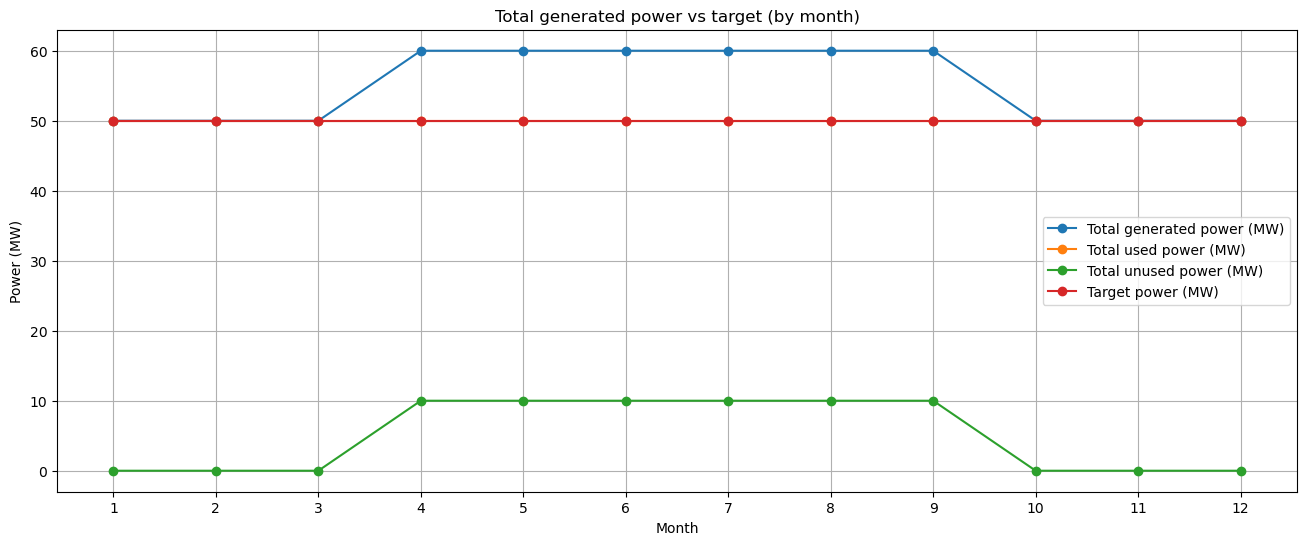

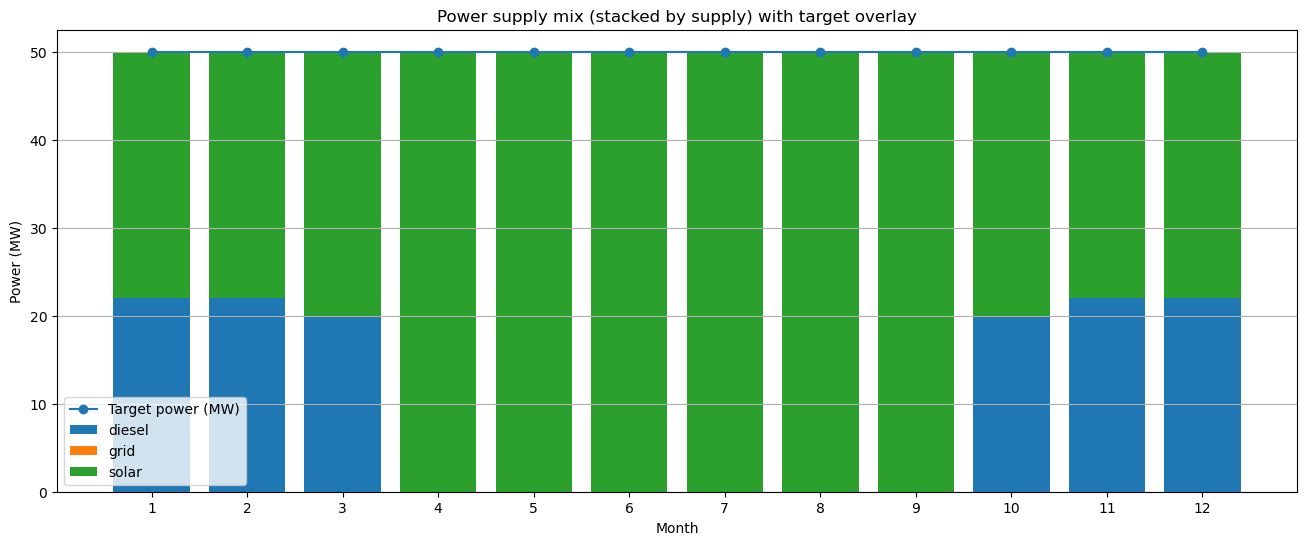

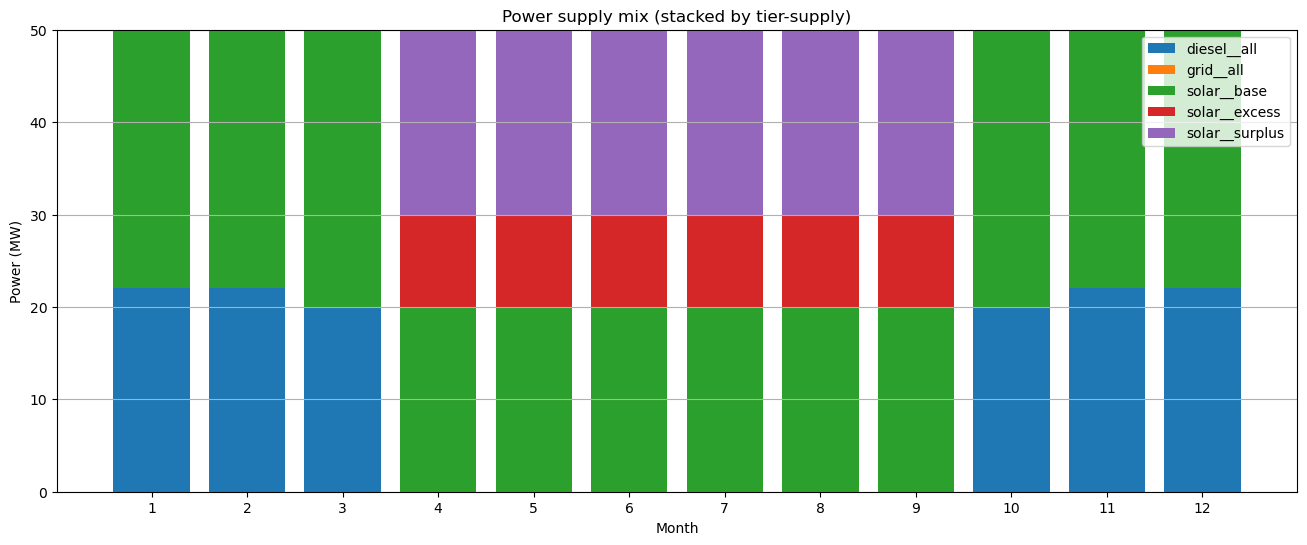

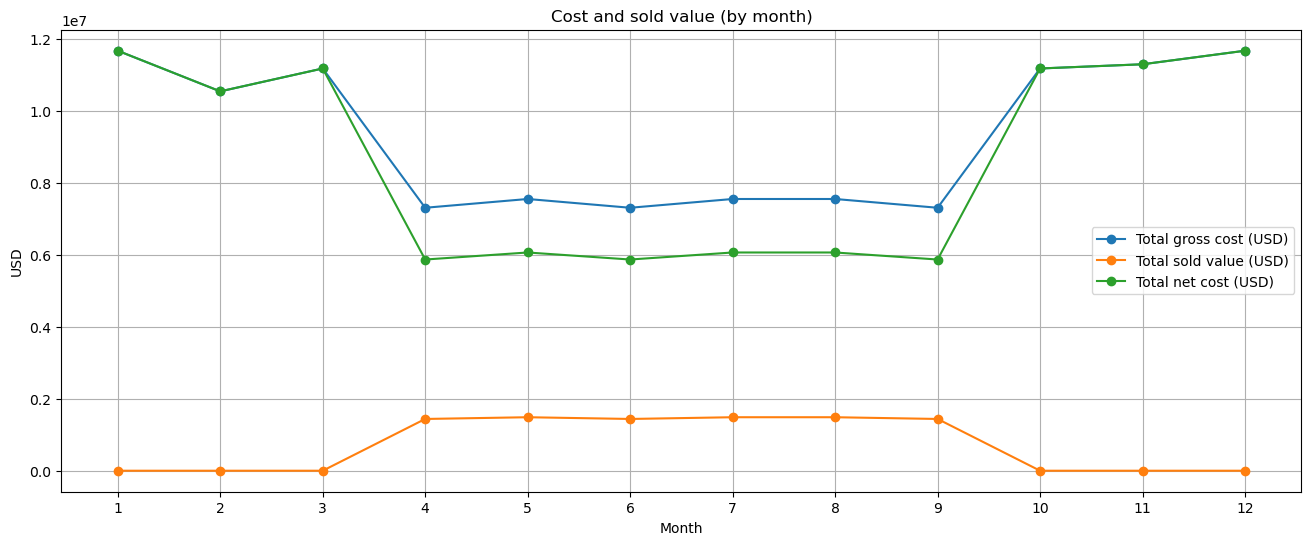

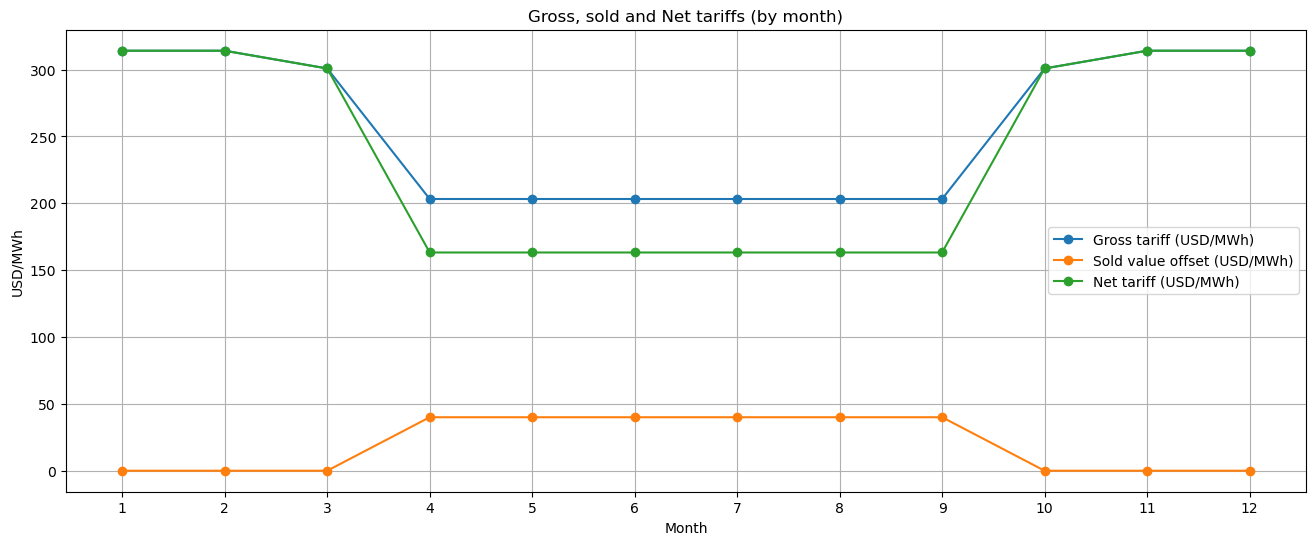

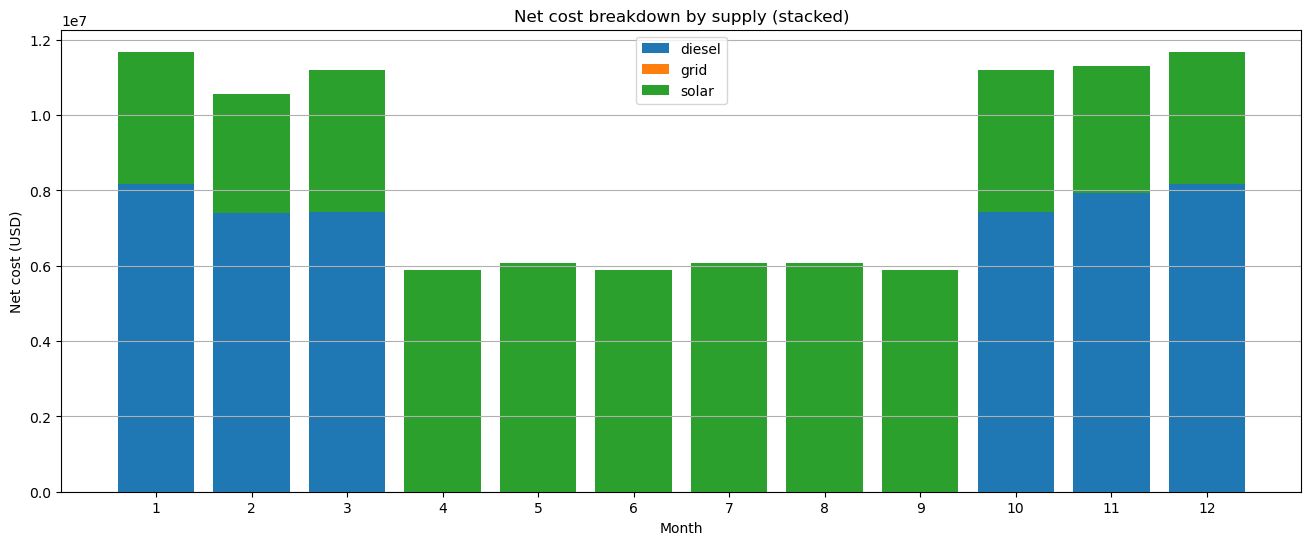

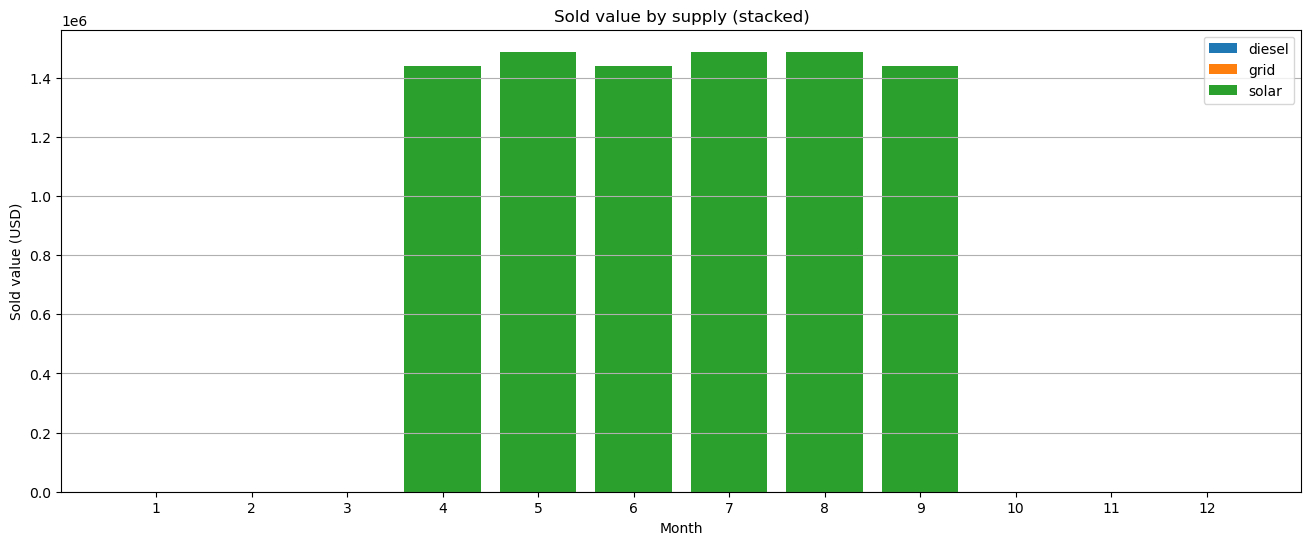

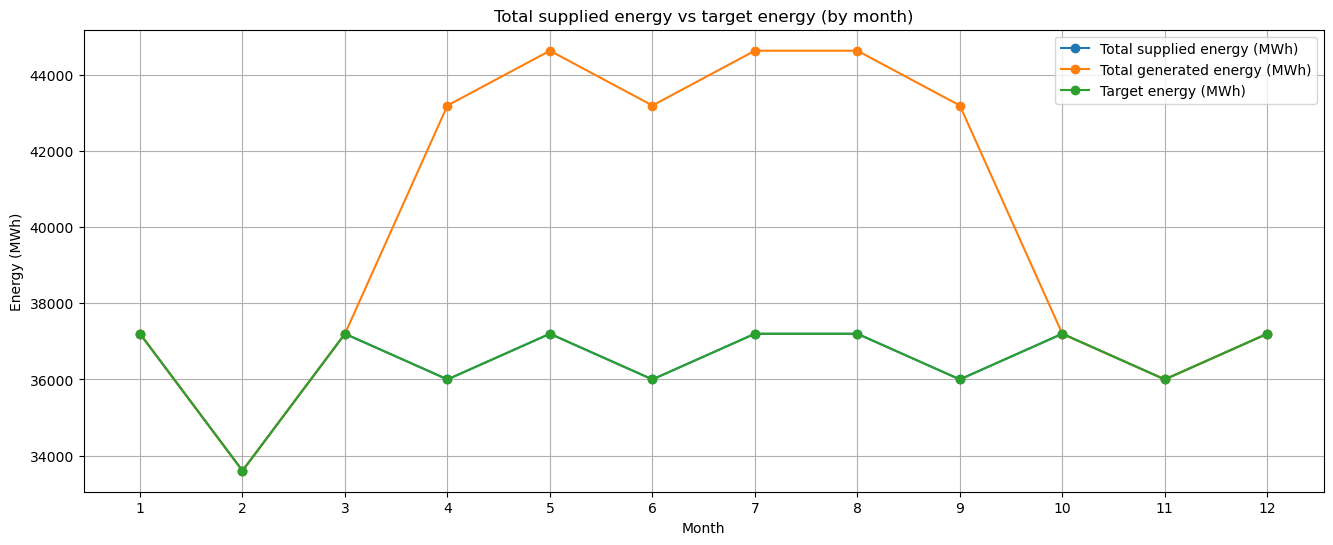

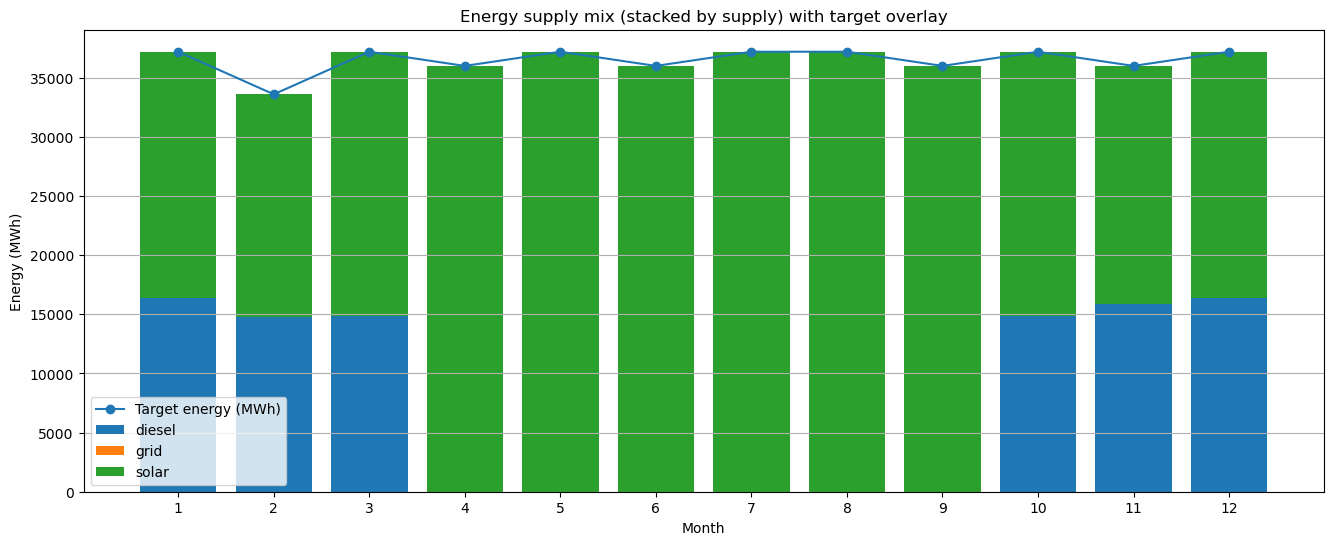

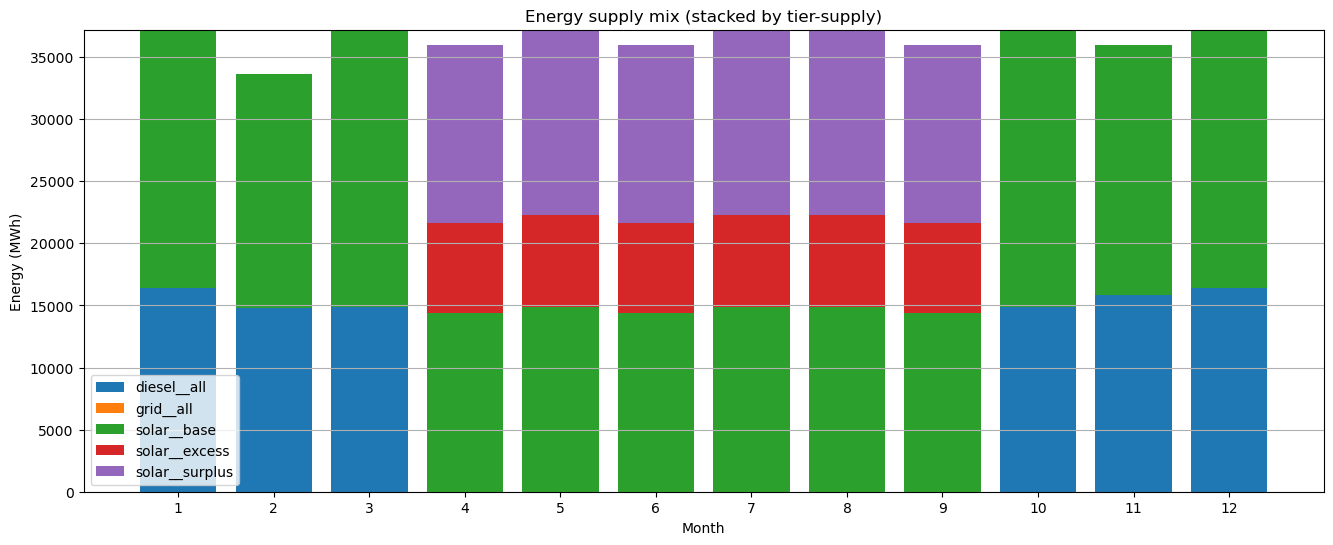

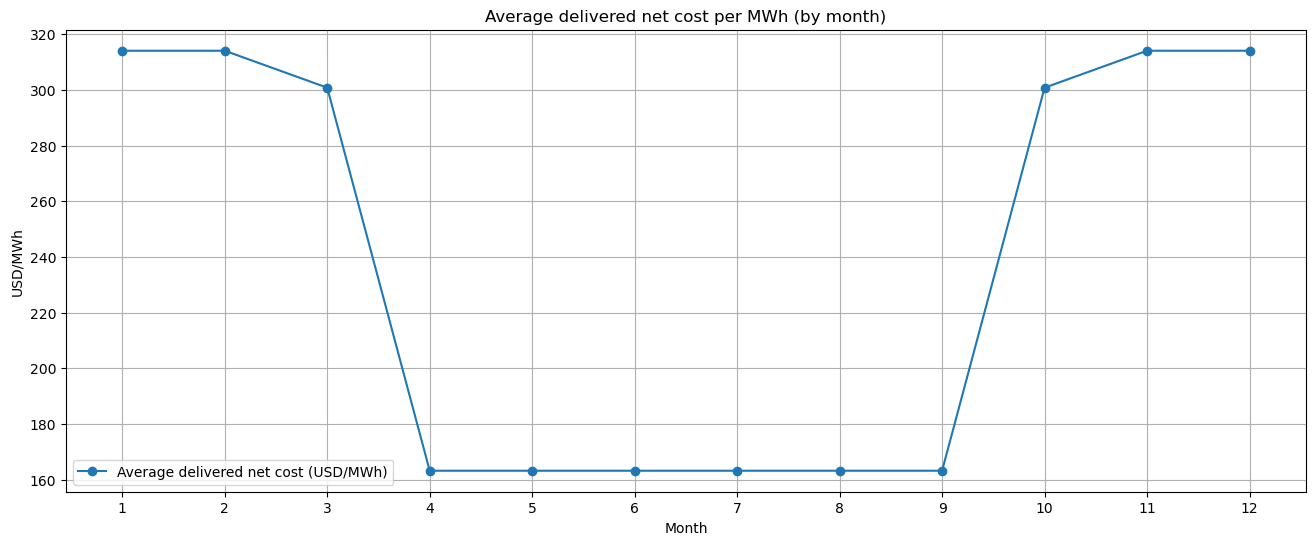

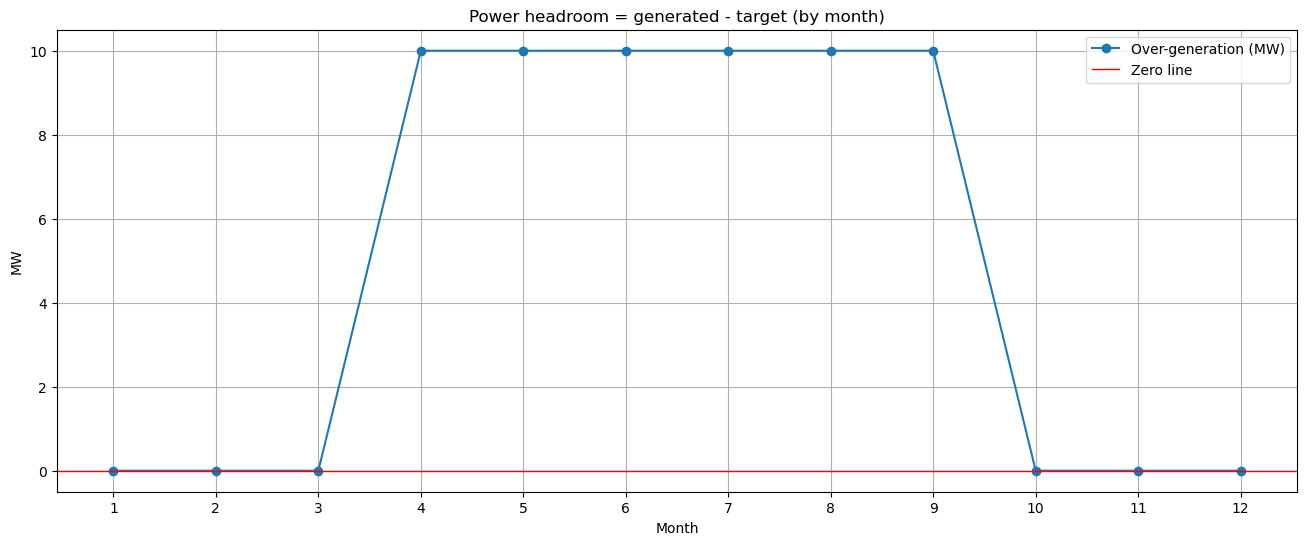

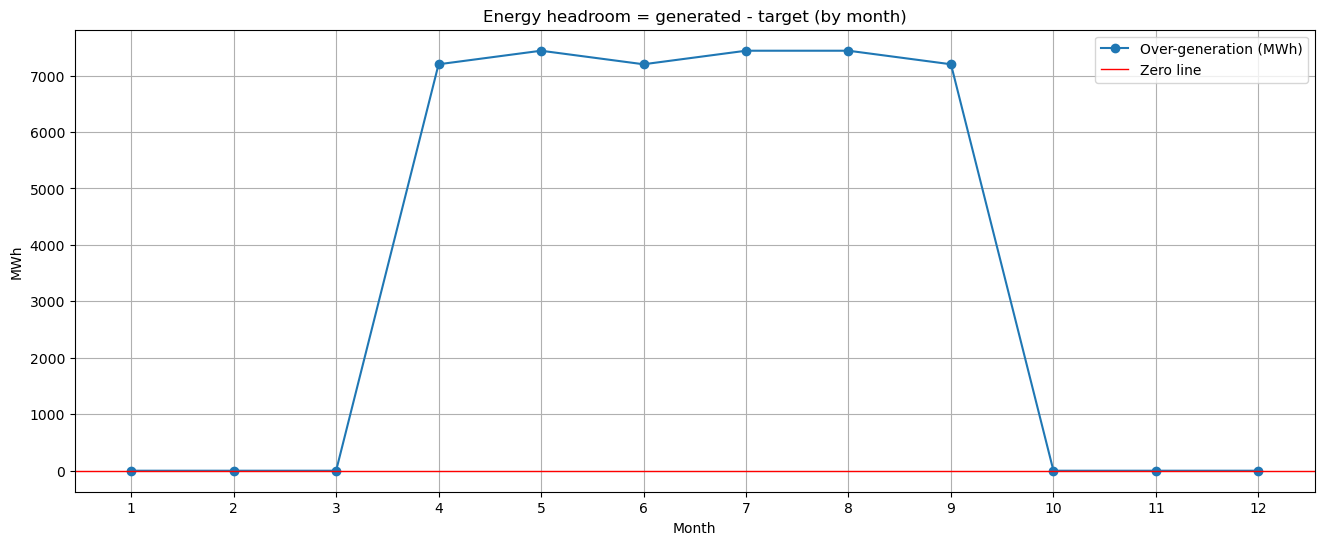

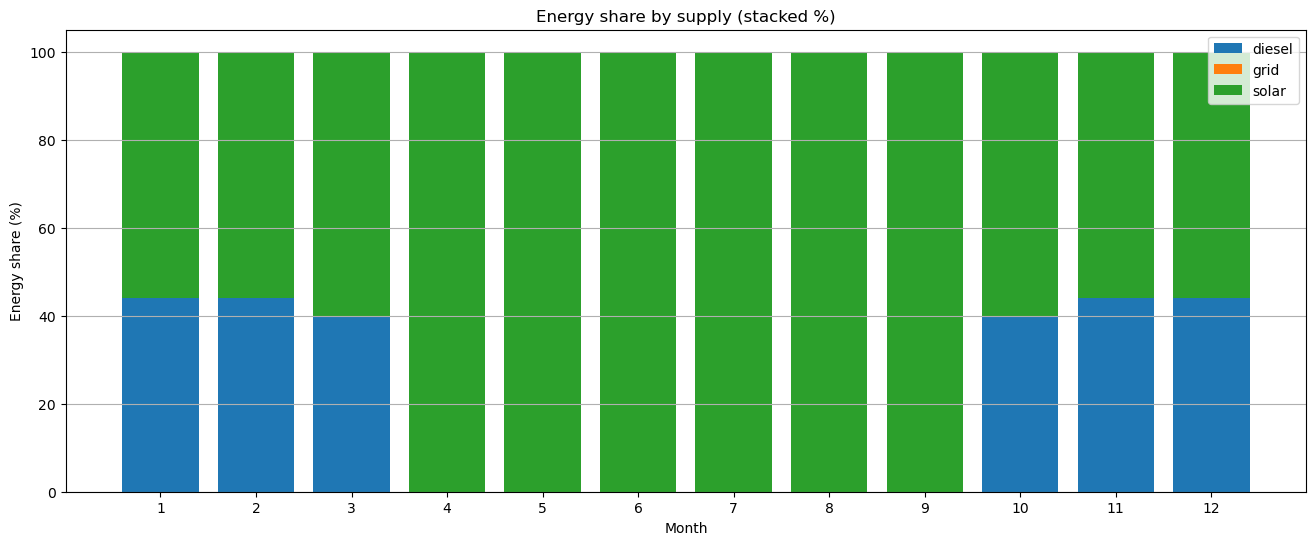

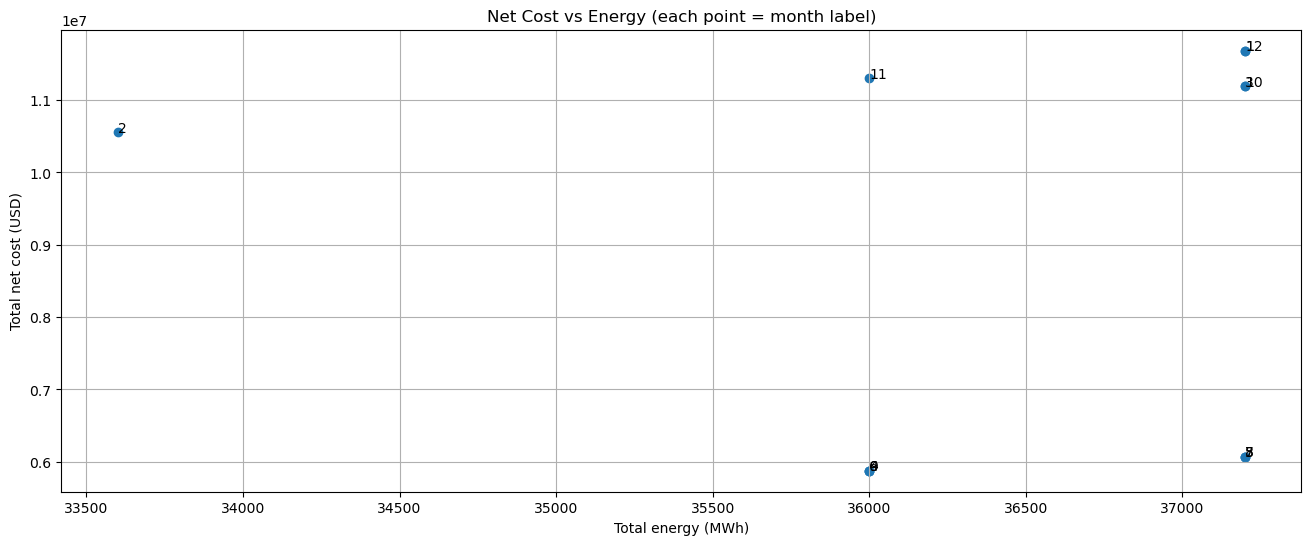

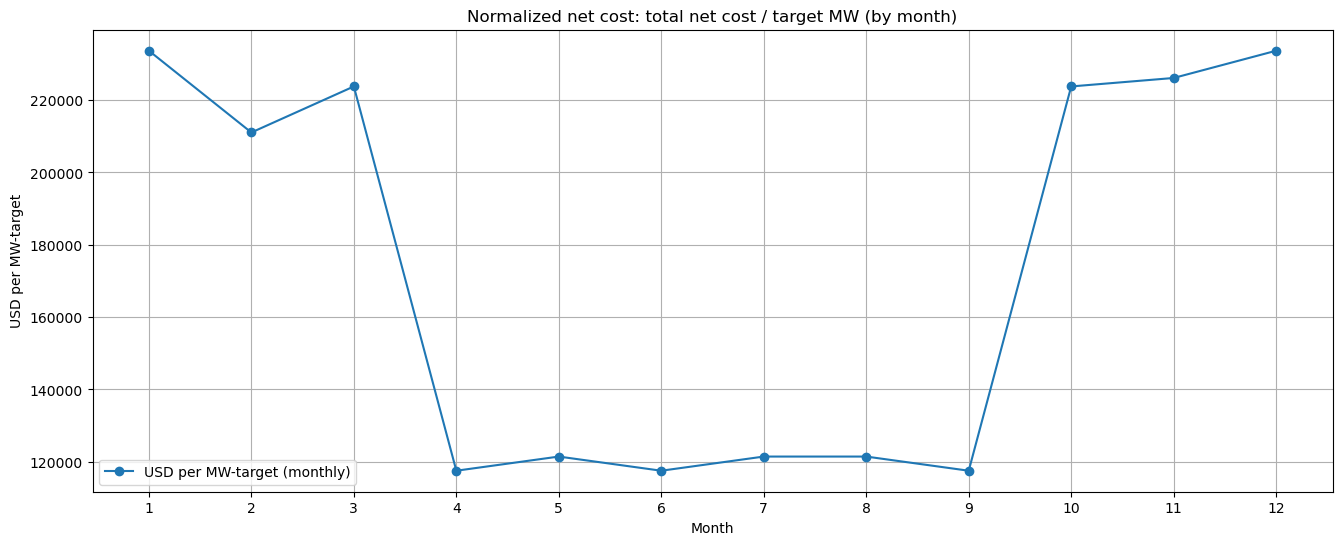

In [42]:
# Cell 9 — Plots (tier-aware + sold value)
# Run AFTER Cell 6 (requires: df, T_MW, H, months)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (16, 6)   # width, height in inches

months_sorted = sorted(df["month"].unique())

# --- Prepare pivots (USED) ---
power_pivot_supply = df.pivot_table(index="month", columns="supply", values="Power_MW", aggfunc="sum").fillna(0)
energy_pivot_supply = df.pivot_table(index="month", columns="supply", values="Energy_MWh", aggfunc="sum").fillna(0)

power_pivot_tier = df.pivot_table(index="month", columns="tier_supply", values="Power_MW", aggfunc="sum").fillna(0)
energy_pivot_tier = df.pivot_table(index="month", columns="tier_supply", values="Energy_MWh", aggfunc="sum").fillna(0)

# --- Prepare pivots (GENERATED) ---
gen_power_pivot_supply = df.pivot_table(index="month", columns="supply", values="Generated_MW", aggfunc="sum").fillna(0)
gen_energy_pivot_supply = df.pivot_table(index="month", columns="supply", values="Generated_MWh", aggfunc="sum").fillna(0)

# --- Costs / sold value ---
net_cost_pivot_supply = df.pivot_table(index="month", columns="supply", values="NetCost_USD", aggfunc="sum").fillna(0)
gross_cost_pivot_supply = df.pivot_table(index="month", columns="supply", values="GrossCost_USD", aggfunc="sum").fillna(0)
sold_value_pivot_supply = df.pivot_table(index="month", columns="supply", values="SoldValue_USD", aggfunc="sum").fillna(0)

# Targets
target_power = pd.Series({m: T_MW[m] for m in months_sorted}).sort_index()          # MW
hours_series = pd.Series({m: H[m] for m in months_sorted}).sort_index()            # hours
target_energy = target_power * hours_series                                        # MWh

# Totals (USED)
total_power = power_pivot_supply.sum(axis=1).reindex(months_sorted)                # MW
total_energy = energy_pivot_supply.sum(axis=1).reindex(months_sorted)              # MWh

# Totals (GENERATED)
total_generated_power = gen_power_pivot_supply.sum(axis=1).reindex(months_sorted)  # MW
total_generated_energy = gen_energy_pivot_supply.sum(axis=1).reindex(months_sorted)  # MWh

# Totals (COST)
total_net_cost = net_cost_pivot_supply.sum(axis=1).reindex(months_sorted)
total_gross_cost = gross_cost_pivot_supply.sum(axis=1).reindex(months_sorted)
total_sold_value = sold_value_pivot_supply.sum(axis=1).reindex(months_sorted)


def stacked_bar(pivot_df: pd.DataFrame, title: str, ylabel: str, overlay_line=None, overlay_label=None):
    plt.figure()
    bottom = np.zeros(len(months_sorted))
    pivot_df = pivot_df.reindex(months_sorted).fillna(0)

    for col in pivot_df.columns:
        vals = pivot_df[col].values
        plt.bar(months_sorted, vals, bottom=bottom, label=str(col))
        bottom += vals

    if overlay_line is not None:
        plt.plot(months_sorted, overlay_line.reindex(months_sorted).values, marker="o", label=overlay_label)

    plt.xticks(months_sorted)
    plt.xlabel("Month")
    plt.ylabel(ylabel)
    plt.title(title)

    handles, labels = plt.gca().get_legend_handles_labels()
    if labels:
        plt.legend()

    plt.grid(True, axis="y")
    plt.show()


# 1) Total generated power vs target power
# Calculate unused power (generated - used)
total_unused_power = total_generated_power - total_power

plt.figure()
plt.plot(months_sorted, total_generated_power.values, marker="o", label="Total generated power (MW)")
plt.plot(months_sorted, total_power.values, marker="o", label="Total used power (MW)")
plt.plot(months_sorted, total_unused_power.values, marker="o", label="Total unused power (MW)")
plt.plot(months_sorted, target_power.values, marker="o", label="Target power (MW)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Power (MW)")
plt.title("Total generated power vs target (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 1b) Power supply mix (stacked by SUPPLY) + target overlay (USED)
stacked_bar(
    power_pivot_supply,
    title="Power supply mix (stacked by supply) with target overlay",
    ylabel="Power (MW)",
    overlay_line=target_power,
    overlay_label="Target power (MW)",
)

# 1c) Power supply mix (stacked by TIER-SUPPLY) (USED)
stacked_bar(
    power_pivot_tier,
    title="Power supply mix (stacked by tier-supply)",
    ylabel="Power (MW)",
)

# 2) Net cost and sold value by month
plt.figure()
plt.plot(months_sorted, total_gross_cost.values, marker="o", label="Total gross cost (USD)")
plt.plot(months_sorted, total_sold_value.values, marker="o", label="Total sold value (USD)")
plt.plot(months_sorted, total_net_cost.values, marker="o", label="Total net cost (USD)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("USD")
plt.title("Cost and sold value (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 2a) Gross, sold and net tariffs (by month) (USD/MWh on USED energy)
gross_tariff = (total_gross_cost / total_energy).replace([np.inf, -np.inf], np.nan)
sold_tariff = (total_sold_value / total_energy).replace([np.inf, -np.inf], np.nan)
net_tariff = (total_net_cost / total_energy).replace([np.inf, -np.inf], np.nan)

plt.figure()
plt.plot(months_sorted, gross_tariff.values, marker="o", label="Gross tariff (USD/MWh)")
plt.plot(months_sorted, sold_tariff.values, marker="o", label="Sold value offset (USD/MWh)")
plt.plot(months_sorted, net_tariff.values, marker="o", label="Net tariff (USD/MWh)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("USD/MWh")
plt.title("Gross, sold and Net tariffs (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 2b) Net cost breakdown by supply (stacked)
stacked_bar(
    net_cost_pivot_supply,
    title="Net cost breakdown by supply (stacked)",
    ylabel="Net cost (USD)",
)

# 2c) Sold value by supply (stacked)
stacked_bar(
    sold_value_pivot_supply,
    title="Sold value by supply (stacked)",
    ylabel="Sold value (USD)",
)

# 3) Total supplied energy vs target energy (include total generated energy)
plt.figure()
plt.plot(months_sorted, total_energy.values, marker="o", label="Total supplied energy (MWh)")
plt.plot(months_sorted, total_generated_energy.values, marker="o", label="Total generated energy (MWh)")
plt.plot(months_sorted, target_energy.values, marker="o", label="Target energy (MWh)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Energy (MWh)")
plt.title("Total supplied energy vs target energy (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 3b) Energy mix (stacked by SUPPLY) + target overlay (USED)
stacked_bar(
    energy_pivot_supply,
    title="Energy supply mix (stacked by supply) with target overlay",
    ylabel="Energy (MWh)",
    overlay_line=target_energy,
    overlay_label="Target energy (MWh)",
)

# 3c) Energy mix (stacked by TIER-SUPPLY) (USED)
stacked_bar(
    energy_pivot_tier,
    title="Energy supply mix (stacked by tier-supply)",
    ylabel="Energy (MWh)",
)

# A) Average delivered unit cost (USD/MWh) each month (NET on USED energy)
avg_unit_cost = (total_net_cost / total_energy).replace([np.inf, -np.inf], np.nan)
plt.figure()
plt.plot(months_sorted, avg_unit_cost.values, marker="o", label="Average delivered net cost (USD/MWh)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("USD/MWh")
plt.title("Average delivered net cost per MWh (by month)")
plt.legend()
plt.grid(True)
plt.show()

# B) Over-generation above target (MW and MWh) (on GENERATED)
power_margin = total_generated_power - target_power
energy_margin = total_generated_energy - target_energy

plt.figure()
plt.plot(months_sorted, power_margin.values, marker="o", label="Over-generation (MW)")
plt.axhline(0, color='red', linestyle='-', linewidth=1, label='Zero line')
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("MW")
plt.title("Power headroom = generated - target (by month)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(months_sorted, energy_margin.values, marker="o", label="Over-generation (MWh)")
plt.axhline(0, color='red', linestyle='-', linewidth=1, label='Zero line')
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("MWh")
plt.title("Energy headroom = generated - target (by month)")
plt.legend()
plt.grid(True)
plt.show()

# C) Energy share (%) by supply (stacked) (USED)
energy_share_pct = energy_pivot_supply.div(energy_pivot_supply.sum(axis=1), axis=0).fillna(0).reindex(months_sorted) * 100.0

plt.figure()
bottom = np.zeros(len(months_sorted))
for s in energy_share_pct.columns:
    vals = energy_share_pct[s].values
    plt.bar(months_sorted, vals, bottom=bottom, label=str(s))
    bottom += vals
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Energy share (%)")
plt.title("Energy share by supply (stacked %)")
plt.legend()
plt.grid(True, axis="y")
plt.show()

# D) Correlation-style view: Net Cost vs Energy (by month) (USED)
plt.figure()
plt.scatter(total_energy.values, total_net_cost.values)
for i, m in enumerate(months_sorted):
    plt.annotate(str(m), (total_energy.values[i], total_net_cost.values[i]))
plt.xlabel("Total energy (MWh)")
plt.ylabel("Total net cost (USD)")
plt.title("Net Cost vs Energy (each point = month label)")
plt.grid(True)
plt.show()

# E) Monthly net cost per MW of target (useful normalization)
cost_per_target_mw = total_net_cost / target_power.replace(0, np.nan)
plt.figure()
plt.plot(months_sorted, cost_per_target_mw.values, marker="o", label="USD per MW-target (monthly)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("USD per MW-target")
plt.title("Normalized net cost: total net cost / target MW (by month)")
plt.legend()
plt.grid(True)
plt.show()


## Yearly Aggregated Results

YEARLY SUMMARY
Total Energy Used (MWh):        438,000.00
Total Energy Generated (MWh):   481,920.00
Target Energy (MWh):            438,000.00
Total Gross Cost (USD):         112,229,760.00
Total Sold Value (USD):         8,784,000.00
Total Net Cost (USD):           103,445,760.00
Average Gross Tariff (USD/MWh): 256.23
Average Sold Offset (USD/MWh):  20.05
Average Net Tariff (USD/MWh):   236.18


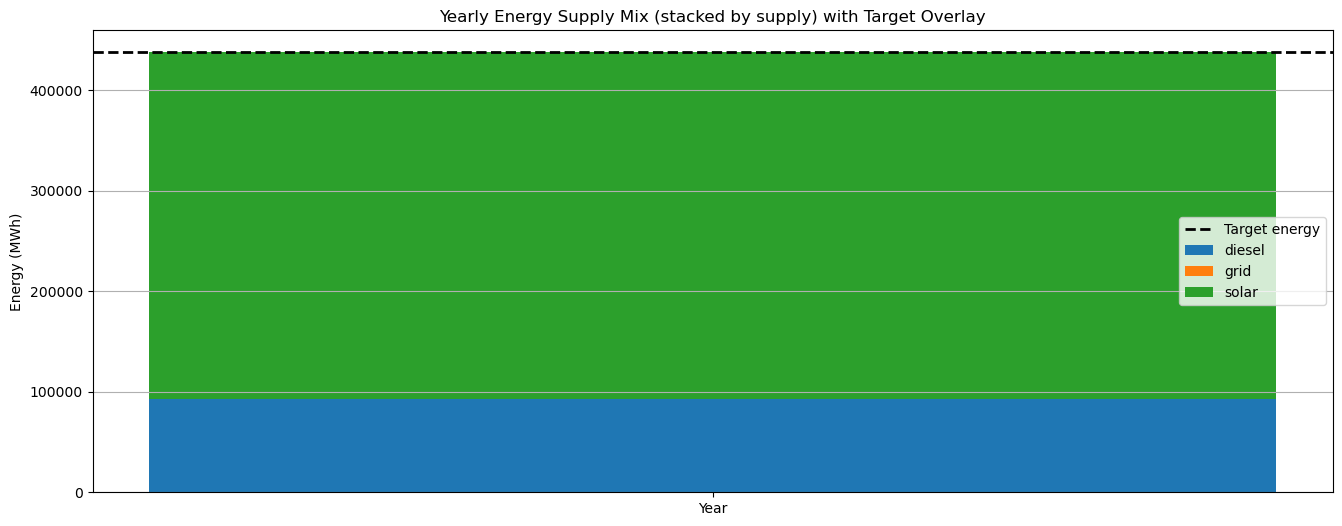

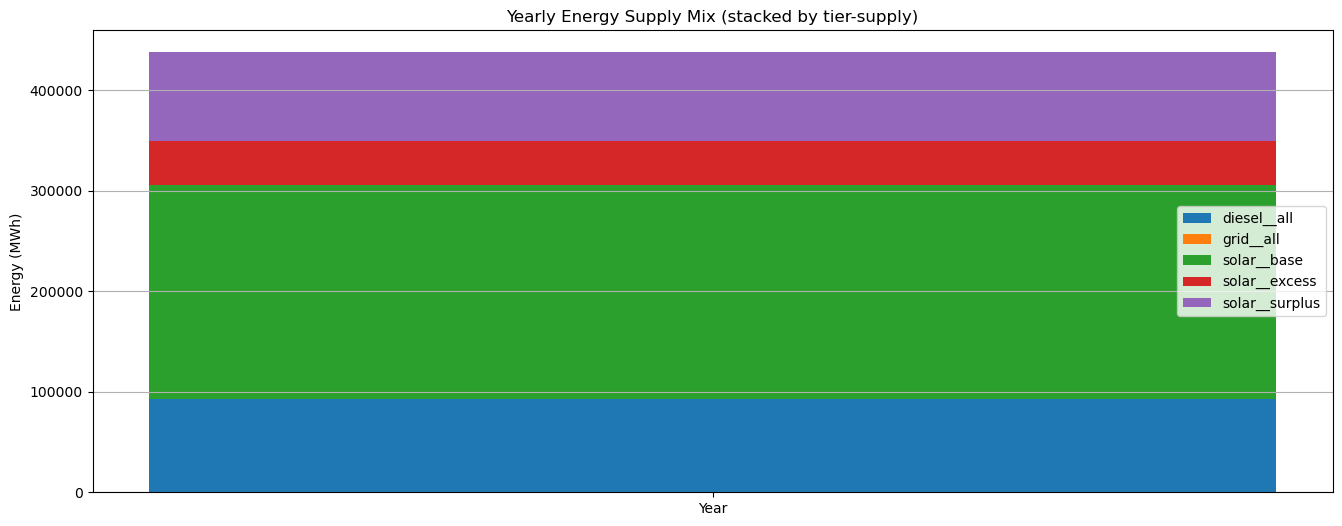

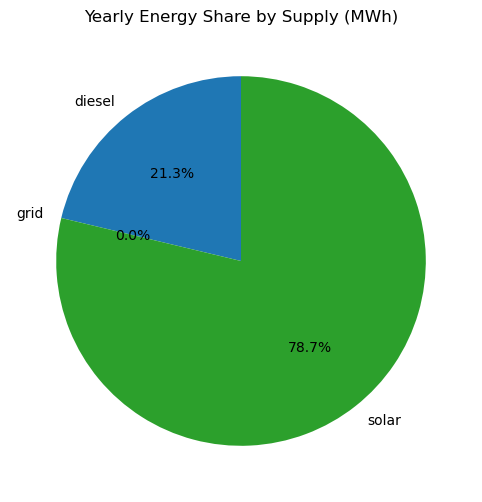

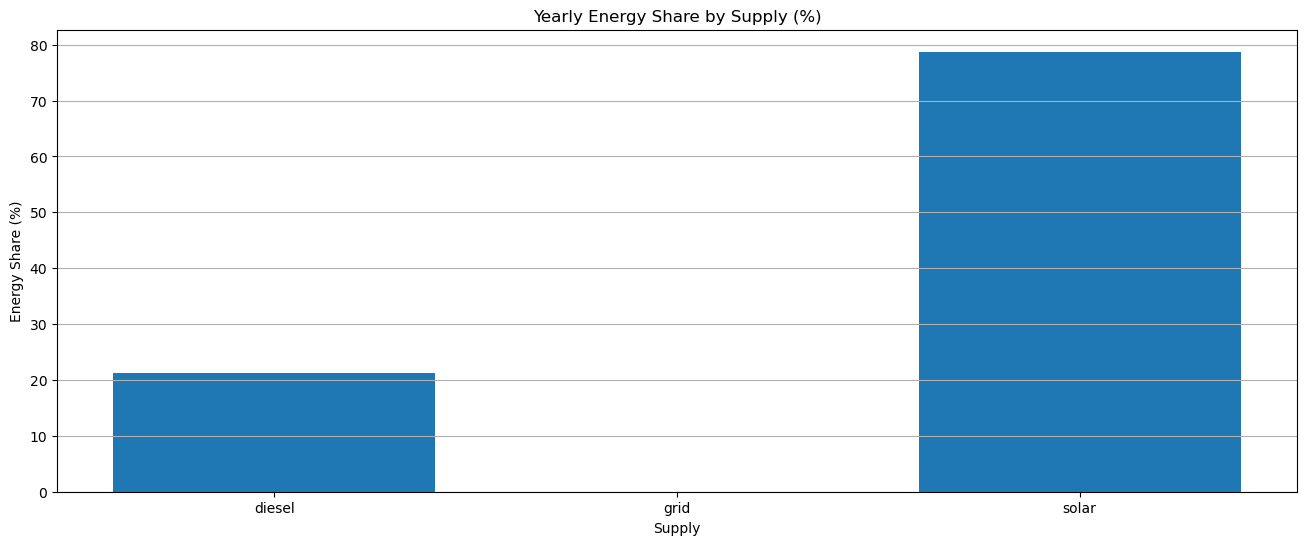

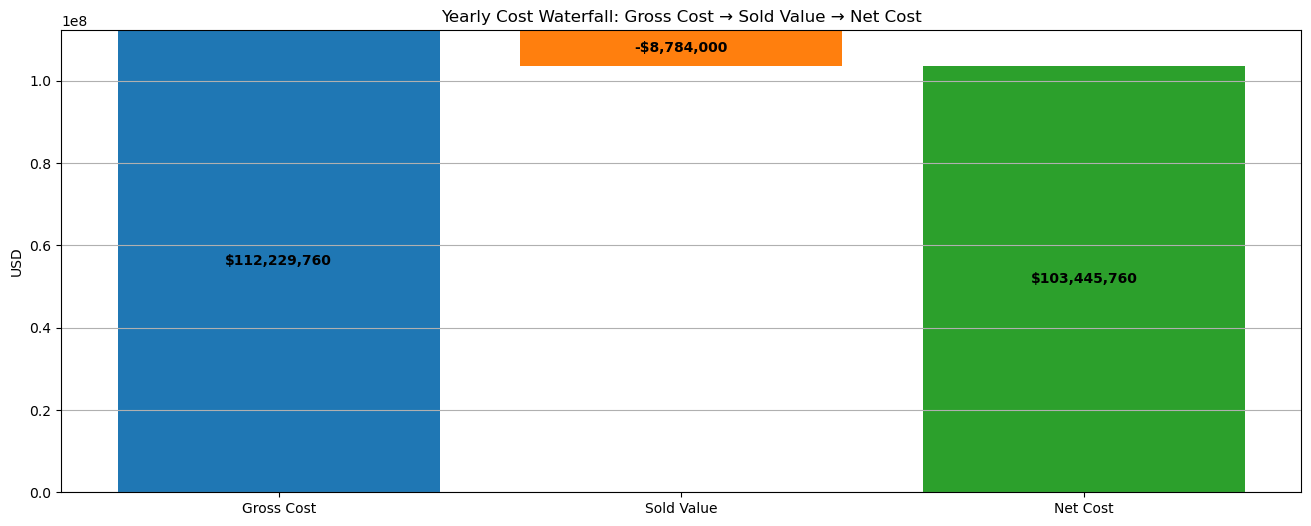

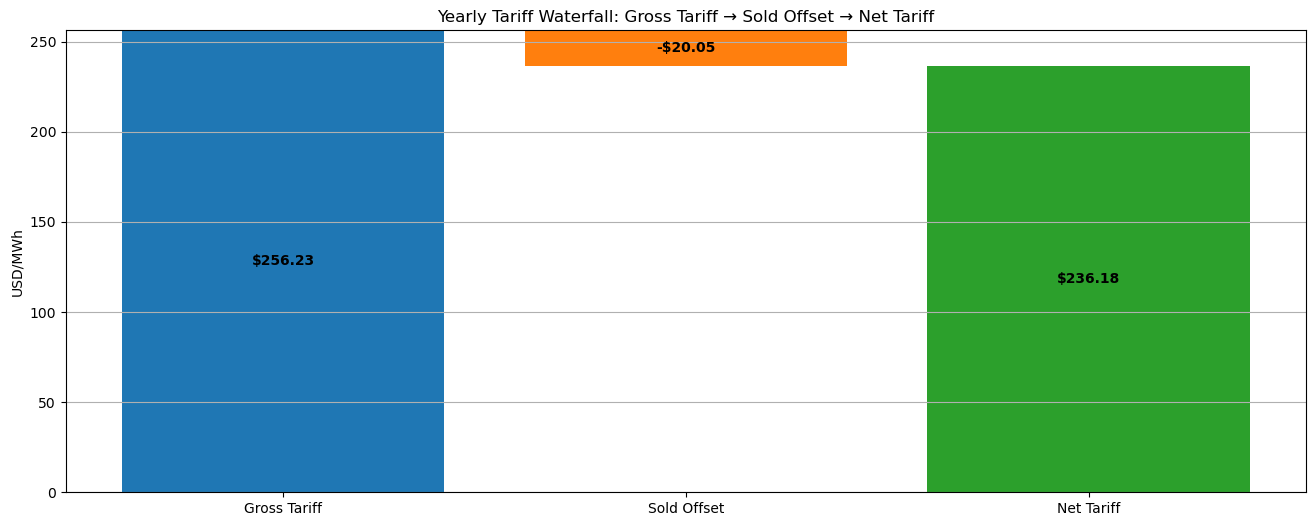


Yearly Summary by Supply:


,supply,TotalEnergy_MWh,TotalGeneratedEnergy_MWh,TotalSoldEnergy_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD
0,diesel,93120.0,93120.0,0.0,46560000.0,0.0,46560000.0
1,grid,0.0,0.0,0.0,0.0,0.0,0.0
2,solar,344880.0,388800.0,43920.0,65669760.0,8784000.0,56885760.0



Yearly Summary by Tier-Supply:


,tier_supply,TotalEnergy_MWh,TotalGeneratedEnergy_MWh,TotalSoldEnergy_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD
0,diesel__all,93120.0,93120.0,0.0,46560000.0,0.0,46560000.0
1,grid__all,0.0,0.0,0.0,0.0,0.0,0.0
2,solar__base,213120.0,257040.0,43920.0,43182720.0,8784000.0,34398720.0
3,solar__excess,43920.0,43920.0,0.0,7554240.0,0.0,7554240.0
4,solar__surplus,87840.0,87840.0,0.0,14932800.0,0.0,14932800.0


In [ ]:
# Cell 11 — Yearly Aggregated Results
# Run AFTER Cell 9 (requires: df, energy_pivot_supply, energy_pivot_tier, T_MW, H, months)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Aggregate data for the year
yearly_summary = df.groupby("supply", as_index=False).agg(
    TotalEnergy_MWh=("Energy_MWh", "sum"),
    TotalGeneratedEnergy_MWh=("Generated_MWh", "sum"),
    TotalSoldEnergy_MWh=("Sold_MWh", "sum"),
    TotalGrossCost_USD=("GrossCost_USD", "sum"),
    TotalSoldValue_USD=("SoldValue_USD", "sum"),
    TotalNetCost_USD=("NetCost_USD", "sum"),
)

yearly_summary_tier = df.groupby("tier_supply", as_index=False).agg(
    TotalEnergy_MWh=("Energy_MWh", "sum"),
    TotalGeneratedEnergy_MWh=("Generated_MWh", "sum"),
    TotalSoldEnergy_MWh=("Sold_MWh", "sum"),
    TotalGrossCost_USD=("GrossCost_USD", "sum"),
    TotalSoldValue_USD=("SoldValue_USD", "sum"),
    TotalNetCost_USD=("NetCost_USD", "sum"),
)

# Calculate yearly target
yearly_target_energy = sum(T_MW[m] * H[m] for m in months)

# Total yearly values
total_yearly_energy = yearly_summary["TotalEnergy_MWh"].sum()
total_yearly_generated = yearly_summary["TotalGeneratedEnergy_MWh"].sum()
total_yearly_gross_cost = yearly_summary["TotalGrossCost_USD"].sum()
total_yearly_sold_value = yearly_summary["TotalSoldValue_USD"].sum()
total_yearly_net_cost = yearly_summary["TotalNetCost_USD"].sum()

# Calculate average tariffs
avg_gross = total_yearly_gross_cost / total_yearly_energy if total_yearly_energy > 0 else 0
avg_sold = total_yearly_sold_value / total_yearly_energy if total_yearly_energy > 0 else 0
avg_net = total_yearly_net_cost / total_yearly_energy if total_yearly_energy > 0 else 0

print("=" * 60)
print("YEARLY SUMMARY")
print("=" * 60)
print(f"Total Energy Used (MWh):        {total_yearly_energy:,.2f}")
print(f"Total Energy Generated (MWh):   {total_yearly_generated:,.2f}")
print(f"Target Energy (MWh):            {yearly_target_energy:,.2f}")
print(f"Total Gross Cost (USD):         {total_yearly_gross_cost:,.2f}")
print(f"Total Sold Value (USD):         {total_yearly_sold_value:,.2f}")
print(f"Total Net Cost (USD):           {total_yearly_net_cost:,.2f}")
print(f"Average Gross Tariff (USD/MWh): {avg_gross:.2f}")
print(f"Average Sold Offset (USD/MWh):  {avg_sold:.2f}")
print(f"Average Net Tariff (USD/MWh):   {avg_net:.2f}")
print("=" * 60)

plt.rcParams["figure.figsize"] = (16, 6)

# 1) Energy supply mix (stacked by supply) with target overlay
plt.figure()
supplies_list = yearly_summary["supply"].tolist()
energy_by_supply = yearly_summary["TotalEnergy_MWh"].values
bottom = 0
for i, supply in enumerate(supplies_list):
    plt.bar(["Year"], energy_by_supply[i], bottom=bottom, label=supply)
    bottom += energy_by_supply[i]
plt.axhline(yearly_target_energy, color='black', linestyle='--', linewidth=2, label='Target energy')
plt.ylabel("Energy (MWh)")
plt.title("Yearly Energy Supply Mix (stacked by supply) with Target Overlay")
plt.legend()
plt.grid(True, axis="y")
plt.show()

# 2) Energy supply mix (stacked by tier-supply)
plt.figure()
tier_supplies_list = yearly_summary_tier["tier_supply"].tolist()
energy_by_tier = yearly_summary_tier["TotalEnergy_MWh"].values
bottom = 0
for i, tier in enumerate(tier_supplies_list):
    plt.bar(["Year"], energy_by_tier[i], bottom=bottom, label=tier)
    bottom += energy_by_tier[i]
plt.ylabel("Energy (MWh)")
plt.title("Yearly Energy Supply Mix (stacked by tier-supply)")
plt.legend()
plt.grid(True, axis="y")
plt.show()

# 3) Energy share by supply (MWh) - pie chart
plt.figure()
plt.pie(yearly_summary["TotalEnergy_MWh"], labels=yearly_summary["supply"], autopct='%1.1f%%', startangle=90)
plt.title("Yearly Energy Share by Supply (MWh)")
plt.show()

# 4) Energy share by supply (%) - bar chart
plt.figure()
energy_share_pct_yearly = (yearly_summary["TotalEnergy_MWh"] / total_yearly_energy * 100).values
plt.bar(supplies_list, energy_share_pct_yearly)
plt.ylabel("Energy Share (%)")
plt.xlabel("Supply")
plt.title("Yearly Energy Share by Supply (%)")
plt.grid(True, axis="y")
plt.show()

# 5) Waterfall chart for total gross cost / sold value / net cost (USD)
plt.figure()
categories = ["Gross Cost", "Sold Value", "Net Cost"]
x = np.arange(len(categories))

gross = float(total_yearly_gross_cost)
sold = float(total_yearly_sold_value)
net = float(total_yearly_net_cost)

# Draw as: gross (from 0), sold step (drop from gross to gross-sold), net total (from 0)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
plt.bar(x[0], gross, color=colors[0])
plt.bar(x[1], -sold, bottom=gross, color=colors[1])
plt.bar(x[2], net, color=colors[2])

plt.xticks(x, categories)
plt.ylabel("USD")
plt.title("Yearly Cost Waterfall: Gross Cost → Sold Value → Net Cost")

# Add headroom above the highest step
y_max = max(gross, net, gross)
y_min = min(0.0, gross - sold, net)
y_pad = max(1.0, (y_max - y_min) * 0.08)
plt.ylim(y_min, y_max + y_pad)

# Value labels
plt.text(x[0], gross / 2, f"${gross:,.0f}", ha='center', va='center', fontsize=10, fontweight='bold')
plt.text(x[1], gross - sold / 2, f"-${sold:,.0f}", ha='center', va='center', fontsize=10, fontweight='bold')
plt.text(x[2], net / 2, f"${net:,.0f}", ha='center', va='center', fontsize=10, fontweight='bold')

plt.grid(True, axis="y")
plt.show()

# 6) Waterfall chart for gross tariff / sold value offset / net tariff (USD/MWh)
plt.figure()
categories_tariff = ["Gross Tariff", "Sold Offset", "Net Tariff"]
x2 = np.arange(len(categories_tariff))

gross_t = float(avg_gross)
sold_t = float(avg_sold)
net_t = float(avg_net)

colors_tariff = ["#1f77b4", "#ff7f0e", "#2ca02c"]
plt.bar(x2[0], gross_t, color=colors_tariff[0])
plt.bar(x2[1], -sold_t, bottom=gross_t, color=colors_tariff[1])
plt.bar(x2[2], net_t, color=colors_tariff[2])

plt.xticks(x2, categories_tariff)
plt.ylabel("USD/MWh")
plt.title("Yearly Tariff Waterfall: Gross Tariff → Sold Offset → Net Tariff")

# Add headroom above the highest step
y2_max = max(gross_t, net_t, gross_t)
y2_min = min(0.0, gross_t - sold_t, net_t)
y2_pad = max(0.01, (y2_max - y2_min) * 0.08)
plt.ylim(y2_min, y2_max + y2_pad)

plt.text(x2[0], gross_t / 2, f"${gross_t:.2f}", ha='center', va='center', fontsize=10, fontweight='bold')
plt.text(x2[1], gross_t - sold_t / 2, f"-${sold_t:.2f}", ha='center', va='center', fontsize=10, fontweight='bold')
plt.text(x2[2], net_t / 2, f"${net_t:.2f}", ha='center', va='center', fontsize=10, fontweight='bold')

plt.grid(True, axis="y")
plt.show()

print("\nYearly Summary by Supply:")
display(yearly_summary)

print("\nYearly Summary by Tier-Supply:")
display(yearly_summary_tier)